In [14]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import sys

# Append the root directory of the project to the python path
sys.path.append('../')


from utils.dataloaders.get_dataloaders import define_dataloader

from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)

# Define the project root directory name
PROJECT_ROOT_DIR = "latent-communication"

current_dir = os.getcwd()

# Find the project root by walking up the directory tree
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")

os.chdir(current_dir)
# Add the project root and any necessary subdirectories to sys.path
sys.path.insert(0, current_dir) 
sys.path.insert(0, os.path.join(current_dir, "utils"))  # Add the utils directory if needed

In [19]:

# Load the model 
model1 = load_model('vae', 'models/checkpoints/VAE/FMNIST/FMNIST_VAE_32_1.pth',latent_size=32)
model2 = load_model('vae', 'models/checkpoints/VAE/FMNIST/FMNIST_VAE_32_3.pth', latent_size=32)

# Train Loader 
train_loader = define_dataloader('FMNIST', 'VAE', use_test_set=False)

/Users/mariotuci/Documents/latent-communication


In [16]:
# Get images from the dataloader
# Get all images 
# Reconstruction
full_dataset, full_lables, n_classes = train_loader

# Get latent space representation
latent_space1 = model1.get_latent_space(full_dataset)
latent_space2 = model2.get_latent_space(full_dataset)

# Print the sahpe of the latent space
print(latent_space1.shape)
print(latent_space2.shape)

torch.Size([60000, 32])
torch.Size([60000, 32])


In [17]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

def principal_angles(X, Y):
    """
    Calculate the principal angles between two subspaces
    """
    # Perform SVD on the product of the two subspaces
    _, s, _ = randomized_svd(X.T @ Y, n_components=min(X.shape[1], Y.shape[1]))

    # Ensure the singular values are in the valid range [0, 1]
    s = np.clip(s, -1, 1)

    # Calculate the principal angles from the singular values
    angles = np.arccos(s)
    
    return s

# Convert PyTorch tensors to numpy arrays if necessary
latent_space1 = latent_space1.detach().numpy()
latent_space2 = latent_space2.detach().numpy()

# Orthogonalize the latent spaces
latent_space1, _ = np.linalg.qr(latent_space1)
latent_space2, _ = np.linalg.qr(latent_space2)

# Calculate the principal angles between the two latent spaces
angles = principal_angles(latent_space1, latent_space2)

print(angles)


[9.8534352e-01 9.8390579e-01 8.1323981e-01 5.2967739e-01 2.5286070e-01
 3.9426930e-02 3.5243910e-02 3.3897504e-02 3.2777362e-02 3.1381417e-02
 2.7881024e-02 2.7010616e-02 2.6222594e-02 2.5725044e-02 2.2587011e-02
 2.1242207e-02 2.0410005e-02 1.8822053e-02 1.8349921e-02 1.5581504e-02
 1.4347262e-02 1.4080374e-02 1.1756575e-02 1.1400719e-02 1.0119726e-02
 8.1766192e-03 8.1361774e-03 6.4366171e-03 3.5506573e-03 2.3269588e-03
 1.4777821e-03 7.0268492e-04]


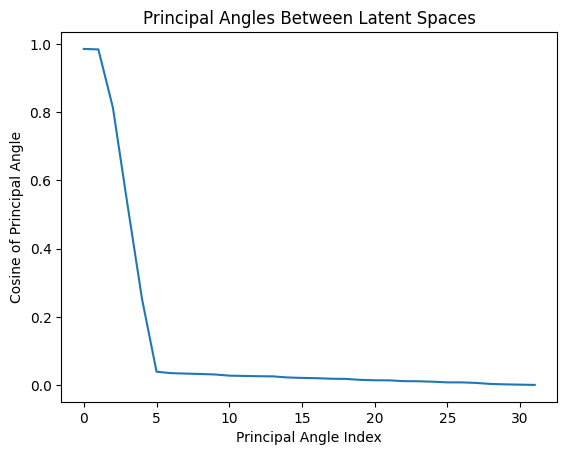

In [18]:
# Plot the principal angles 
plt.plot(angles)
plt.xlabel("Principal Angle Index")
plt.ylabel("Cosine of Principal Angle")
plt.title("Principal Angles Between Latent Spaces")
plt.show()